# Misturando ViT_Gráficos_3 com vit_keras.vit_b16 

In [1]:
!pip install -U tensorflow-addons
!pip install vit_keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=0eadc0d218b2f5caac26a1f19d8e0cff31f87f1a2c59b4b80ac1399a3aa3a2ad
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [77]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 1
n_classes = 7
num_epochs = 30
image_size = 224  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
input_shape = (224, 224, 3)
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [92]:
from pathlib import Path
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import transforms

class_subset = sorted(os.listdir(Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train'))) 

download_dir = Path('/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes')

train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
val_data_dir = download_dir/'val'

train_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size,)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((image_size,image_size),scale=(0.8,1.0),ratio=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

test_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

def augumentation_preproc(image):
    data = {"image":image}
    aug_data = train_transforms(**data)
    aug_img = aug_data["image"]
    return aug_img
    
train_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                      train_data_dir,
                      target_size=(image_size, image_size),
                      class_mode='categorical',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

val_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator = train_datagen.flow_from_directory(
                      val_data_dir,
                      target_size=(image_size, image_size),
                      class_mode='categorical',
                      classes=class_subset,
                      subset='training',
                      batch_size=batch_size, 
                      shuffle=True,
                      seed=42
                  )

Found 280 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


In [5]:
x_train = []
y_train = []
x_train,y_train = next(train_generator)
x_test = []
y_test = []
x_test,y_test = next(valid_generator)

for i in range(len(train_generator)-1):
    x_train = np.append(x_train, train_generator[i+1][0], axis=0)
    y_train = np.append(y_train, train_generator[i+1][1], axis=0)
for i in range(len(valid_generator)-1):
    x_test = np.append(x_test, valid_generator[i+1][0], axis=0)
    y_test = np.append(y_test, valid_generator[i+1][1], axis=0)

In [6]:
y_test = y_test.astype(int).reshape((35,1))
y_train = y_train.astype(int).reshape((280,1))

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [78]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = n_classes)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [95]:
from tensorflow.keras import layers, models

def create_vit_classifier():

  flatten_layer = layers.Flatten()
  dense_layer_1 = layers.Dense(4096, activation='relu')
  dense_layer_2 = layers.Dense(1072, activation='relu')
  dropout = layers.Dropout(0.2)
  prediction_layer = layers.Dense(n_classes, activation='softmax')


  model = models.Sequential([
      data_augmentation,
      vit_model,
      flatten_layer,
      dropout,
      dense_layer_1,
      dropout,
      dense_layer_2,
      prediction_layer
  ])

  optimizer = tfa.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
      ],
  )

  return model

In [96]:
def run_experiment(model):
    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)  


Epoch 1/30
252/252 [==============================] - 47s 123ms/step - loss: 2.1454 - accuracy: 0.2222 - val_loss: 1.8990 - val_accuracy: 0.2143
Epoch 2/30
252/252 [==============================] - 27s 108ms/step - loss: 1.8182 - accuracy: 0.2659 - val_loss: 1.5713 - val_accuracy: 0.2857
Epoch 3/30
252/252 [==============================] - 28s 111ms/step - loss: 1.6813 - accuracy: 0.2460 - val_loss: 1.5388 - val_accuracy: 0.4643
Epoch 4/30
252/252 [==============================] - 21s 84ms/step - loss: 1.5546 - accuracy: 0.2778 - val_loss: 1.7415 - val_accuracy: 0.2143
Epoch 5/30
252/252 [==============================] - 21s 84ms/step - loss: 1.4503 - accuracy: 0.3294 - val_loss: 1.0296 - val_accuracy: 0.4643
Epoch 6/30
252/252 [==============================] - 21s 83ms/step - loss: 1.6672 - accuracy: 0.2659 - val_loss: 1.1772 - val_accuracy: 0.4643
Epoch 7/30
252/252 [==============================] - 21s 83ms/step - loss: 1.5876 - accuracy: 0.2817 - val_loss: 3.7309 - val_accura

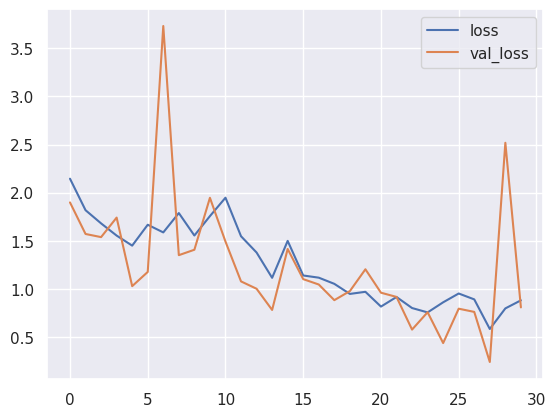

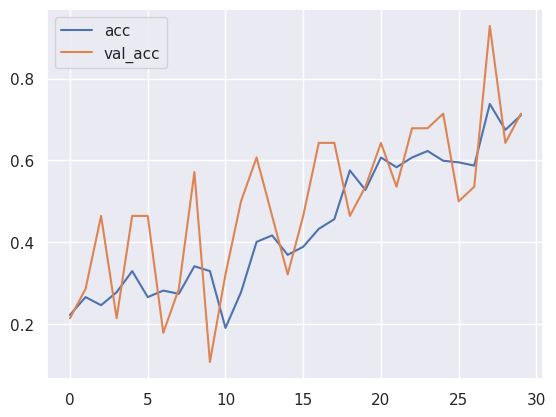

In [97]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [98]:
probs = vit_classifier.predict(x_test)

2/2 [==============================] - 6s 73ms/step


Precisão: 0.8


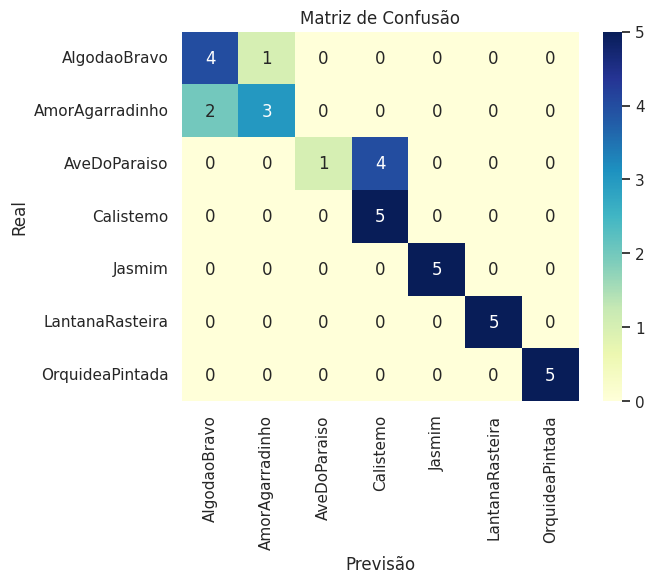

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(probs, axis=1).reshape(35,1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = y_test

# Obter os nomes das classes
class_names = list(valid_generator.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

     


In [100]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Converter as previsões em rótulos de classe
predicted_classes = np.argmax(predictions, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = validgen.classes

# Obter os nomes das classes
class_names = list(validgen.class_indices.keys())

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_classes, target_names=class_names)

# Exibir o relatório de classificação
print(report)

     


NameError: ignored

In [ ]:


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Converter os rótulos verdadeiros em um formato binarizado
n_classes = len(validgen.class_indices)
true_classes_bin = label_binarize(true_classes, classes=list(range(n_classes)))

# Calcular a curva ROC para cada classe usando a estratégia "one-vs-all"
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular a curva ROC média usando a estratégia "one-vs-all"
fpr["micro"], tpr["micro"], _ = roc_curve(true_classes_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar as curvas ROC
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='Curva ROC média (área = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Curva ROC da classe {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

     
